## Big Data in Finance Group Assignment 2

### Foreign Exchange Predictive Model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model, ensemble, svm, neighbors, tree
from sklearn.model_selection import GridSearchCV

%matplotlib inline

#### Read Data

In [2]:
fxSpot = pd.read_excel('FX.xlsx', sheetname = 'FX_Spot', index_col = 'Date')
eurDep = pd.read_excel('FX.xlsx', sheetname = 'EuroDep', index_col = 'Date')
mSupply = pd.read_excel('FX.xlsx', sheetname = 'MoneySupply', index_col = 'Date')
indPrd = pd.read_excel('FX.xlsx', sheetname = 'IndProduction', index_col = 'Date')
cpi = pd.read_excel('FX.xlsx', sheetname = 'CPI', index_col = 'Date')

#### Variable Construction

In [3]:
# Y variable for all currencies
spotDelta_Matrix = np.diff(np.log(fxSpot.as_matrix()), axis = 0)
spotDelta_Matrix = np.insert(spotDelta_Matrix, 0, np.nan, axis = 0)
fxSpotDelta = pd.DataFrame(spotDelta_Matrix, index = fxSpot.index, columns = fxSpot.columns)

# X1 variable
intUSD = eurDep['USD'].as_matrix()
intDiff_Matrix = (eurDep.as_matrix().transpose() - intUSD).transpose()
intDiff = pd.DataFrame(intDiff_Matrix, index = eurDep.index, columns = eurDep.columns)

# X2 variable
inflDelta_Matrix = np.diff(np.log(cpi.as_matrix()), axis = 0)
inflDelta_Matrix = np.insert(inflDelta_Matrix, 0, np.nan, axis = 0)
inflDelta_US = inflDelta_Matrix[ : , inflDelta_Matrix.shape[1] - 1]
inflDiff_Matrix = (inflDelta_Matrix.transpose() - inflDelta_US).transpose()
inflDiff = pd.DataFrame(inflDiff_Matrix, index = cpi.index, columns = cpi.columns)

# X3 variable
indPrd_logMatrix = np.log(indPrd.as_matrix())
indPrd_logUS = indPrd_logMatrix[ : , indPrd_logMatrix.shape[1] - 1]
indPrdDiff_Matrix = (indPrd_logMatrix.transpose() - indPrd_logUS).transpose()
indPrdDiff = pd.DataFrame(indPrdDiff_Matrix, index = indPrd.index, columns = indPrd.columns)

# X4 variable
mSupply_logMatrix = np.log(mSupply.as_matrix())
mSupply_logUS = mSupply_logMatrix[ : , mSupply_logMatrix.shape[1] - 1]
mSupplyDiff_Matrix = (mSupply_logMatrix.transpose() - mSupply_logUS).transpose()
mSupplyDiff = pd.DataFrame(mSupplyDiff_Matrix, index = mSupply.index, columns = mSupply.columns)

In [4]:
def calcMaxDrawDown(cumDiffCurr):
    maxDrawDown = 0
    maxPoint = cumDiffCurr[0]
    for i in range(1, len(cumDiffCurr)):
        if (maxPoint - cumDiffCurr[i]) > maxDrawDown:
            maxDrawDown = (maxPoint - cumDiffCurr[i])
        if cumDiffCurr[i] > maxPoint:
            maxPoint = cumDiffCurr[i]
    return maxDrawDown

In [5]:
#def calcSharpe(HistMeanMatrix):
#    meanAllCurr = np.mean(HistMeanMatrix, axis = 0)
#    covAllCurr = np.cov(HistMeanMatrix.T)
#    weights = np.ones(HistMeanMatrix.shape[1]) / HistMeanMatrix.shape[1]
#    
#    varPortolio = weights.T.dot(covAllCurr.dot(weights))
#    return (np.mean(meanAllCurr) **2 / varPortolio)

#### Rolling Window Method and Plot

In [6]:
def learnAndPlot(windowSize, model, fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff):
    # Windows Size
    w = windowSize

    # Random Forest Param Grid
    #param_grid = {"min_samples_leaf": [1, 3, 10]}

    cumDiffList = [] # Cumulative RMSE difference between prediction model and historical mean
    RsqrOOSList = [] # Final R-Square OOS for different currencies
    histMeanMatrix = []
    
    for currency in fxSpotDelta.columns.values:
        print("Currency = ", currency)
        histMean = []
        histMeanMSE = []
        modelMSE = []
        for yIdx in range(2, fxSpotDelta.shape[0] - w): # First y(i+1) ranges from 3 to 384
            #print("yIdx = ", yIdx)
            xIdx = yIdx - 1
            yMat = fxSpotDelta[currency].as_matrix()
            x1Mat = intDiff[currency].as_matrix()
            x2Mat = inflDiff[currency].as_matrix()
            x3Mat = indPrdDiff[currency].as_matrix()
            x4Mat = mSupplyDiff[currency].as_matrix()
            Y = yMat[yIdx:(yIdx + w)]
            X1 = x1Mat[xIdx:(xIdx + w)]
            X2 = x2Mat[xIdx:(xIdx + w)]
            X3 = x3Mat[xIdx:(xIdx + w)]
            X4 = x4Mat[xIdx:(xIdx + w)]
            X = np.vstack((X1, X2, X3, X4)).T
            # Linear Regression Model
            #model = linear_model.LinearRegression()
            # LASSO with 10-fold cross validation to select the best alpha
            #model = linear_model.LassoCV(cv = 10)
            # Random Forest without Cross Validation
            #model = ensemble.RandomForestRegressor(n_estimators = 20)
            # Random Forest with Grid Search CV
            #model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, cv = 10)
            model.fit(X, Y)
            PredX = np.array([[x1Mat[xIdx + w], x2Mat[xIdx + w], x3Mat[xIdx + w], x4Mat[xIdx + w]]])
            YhistPred = np.mean(Y)
            YModelPred = model.predict(PredX)
            actY = yMat[yIdx + w]
            histMean.append(YhistPred)
            histMeanMSE.append((YhistPred - actY)**2)
            modelMSE.append((YModelPred[0] - actY)**2)

        # All the historical mean forecasts
        histMeanMatrix.append(histMean)
        
        # RMSE
        histMeanRMSE = np.sqrt(np.array(histMeanMSE))
        modelRMSE= np.sqrt(np.array(modelMSE))
        diffRMSE = histMeanRMSE - modelRMSE
        # R-Square OOS
        RsqrOOS = 1 - (np.sum(np.array(modelMSE)) / np.sum(np.array(histMeanMSE)))

        cumDiffList.append(np.insert(diffRMSE.cumsum(), 0, np.zeros(2 + w)))
        RsqrOOSList.append(RsqrOOS)

    cumDiff = np.array(cumDiffList).transpose()
    RsqrOOSAll = np.array(RsqrOOSList)
    histMeanMatrix = np.array(histMeanMatrix).transpose()
    #histMeanMatrix = fxSpotDelta.as_matrix()[(2 + w):, :]
    
    plt.figure(figsize = (10, 6))
    datesList = [datetime.strptime(str(date), '%Y%m').date() for date in fxSpotDelta.index.values]
    for i in range(cumDiff.shape[1]):
        plt.plot(datesList, cumDiff[:, i], label = fxSpotDelta.columns.values[i])
    plt.axhline(0, color = 'grey', ls = 'dashed')
    plt.legend(loc = 'lower left')
    plt.title("Cumulative RMSE Difference vs Month")
    plt.xlabel("Month")
    plt.ylabel("Cumulative RMSE Difference")
    plt.show()
    plt.close()
    
    return cumDiff, RsqrOOSAll, histMeanMatrix

#### Learn With Linear Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


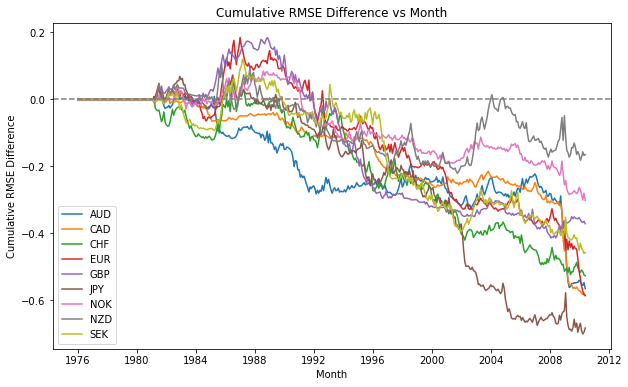

In [7]:
w = 60

# Linear Regression
linRegrCumDiff, linRegrRsqOOS, linRegrHistMean = learnAndPlot(w, linear_model.LinearRegression(), fxSpotDelta, intDiff, 
                                                              inflDiff, indPrdDiff, mSupplyDiff)

In [11]:
print("Mean R-Sq OOS over all currencies: ", np.mean(linRegrRsqOOS))

Mean R-Sq OOS over all currencies:  -0.139406106455


In [12]:
#print("Performance compared to Historical Mean:", np.mean(linRegrRsqOOS) / calcSharpe(linRegrHistMean) * 100, "%")
print("Performance compared to Stock Sharpe Ratio:", np.mean(linRegrRsqOOS) / 0.012 * 100, "%")

Performance compared to Stock Sharpe Ratio: -1161.71755379 %


In [13]:
for i in range(linRegrCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(linRegrCumDiff[ : , i]))

Max DrawDown of  AUD : 0.592630592764
Max DrawDown of  CAD : 0.605163391378
Max DrawDown of  CHF : 0.584355667841
Max DrawDown of  EUR : 0.769561745882
Max DrawDown of  GBP : 0.598618006155
Max DrawDown of  JPY : 0.773388476623
Max DrawDown of  NOK : 0.386477912487
Max DrawDown of  NZD : 0.327877088457
Max DrawDown of  SEK : 0.579840064562


#### Learn With LASSO Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


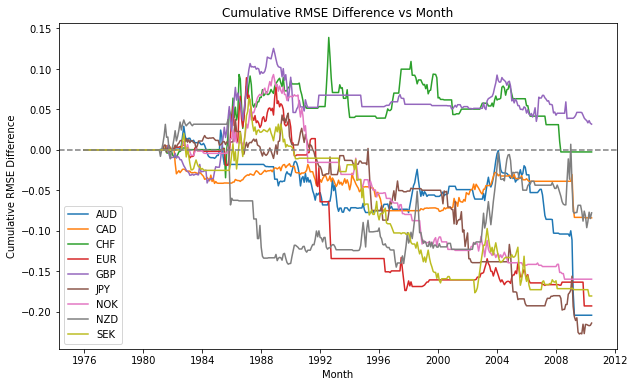

In [14]:
# LASSO Regression with alphas selected by 10-fold Cross Validation
lassoCumDiff, lassoRsqOOS, lassoHistMean = learnAndPlot(w, linear_model.LassoCV(cv = 10, normalize = True), fxSpotDelta, 
                                                        intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [15]:
print("Mean R-Sq OOS over all currencies: ", np.mean(lassoRsqOOS))

Mean R-Sq OOS over all currencies:  -0.0375217229901


In [16]:
#print("Performance compared to Historical Mean:", np.mean(lassoRsqOOS) / calcSharpe(lassoHistMean) * 100, "%")
print("Performance compared to Stock Sharpe Ratio:", np.mean(lassoRsqOOS) / 0.012 * 100, "%")

Performance compared to Stock Sharpe Ratio: -312.681024918 %


In [18]:
for i in range(lassoCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(lassoCumDiff[ : , i]))

Max DrawDown of  AUD : 0.233411404511
Max DrawDown of  CAD : 0.0890770174306
Max DrawDown of  CHF : 0.141409681094
Max DrawDown of  EUR : 0.281885428059
Max DrawDown of  GBP : 0.0935698898761
Max DrawDown of  JPY : 0.272747770619
Max DrawDown of  NOK : 0.2527940598
Max DrawDown of  NZD : 0.182087726628
Max DrawDown of  SEK : 0.244497607686


#### Learn With Random Forest Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


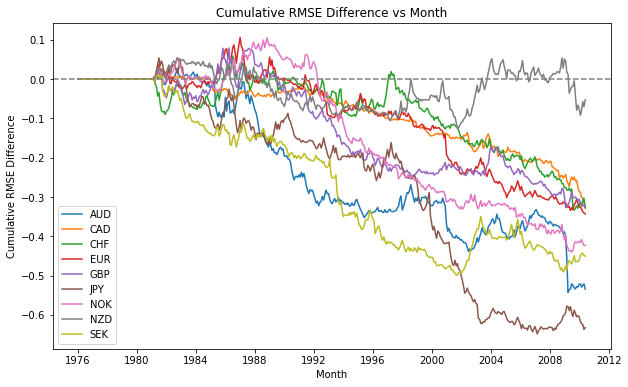

In [19]:
# Random Forest Regression with min_samples_leaf selected by 10-fold Cross Validation
param_grid = {"min_samples_leaf": [1, 3, 10]}
rfCumDiff, rfRsqOOS, rfHistMean = learnAndPlot(w, GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                               param_grid = param_grid, cv = 10), 
                                               fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [20]:
print("Mean R-Sq OOS over all currencies: ", np.mean(rfRsqOOS))

Mean R-Sq OOS over all currencies:  -0.0981328119804


In [21]:
#print("Performance compared to Historical Mean:", np.mean(rfRsqOOS) / calcSharpe(rfHistMean) * 100, "%")
print("Performance compared to Stock Sharpe Ratio:", np.mean(rfRsqOOS) / 0.012 * 100, "%")

Performance compared to Stock Sharpe Ratio: -817.77343317 %


In [22]:
for i in range(rfCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(rfCumDiff[ : , i]))

Max DrawDown of  AUD : 0.570315276365
Max DrawDown of  CAD : 0.356211551159
Max DrawDown of  CHF : 0.392316287132
Max DrawDown of  EUR : 0.449315420515
Max DrawDown of  GBP : 0.406736507077
Max DrawDown of  JPY : 0.702777045531
Max DrawDown of  NOK : 0.545470676444
Max DrawDown of  NZD : 0.18103466232
Max DrawDown of  SEK : 0.508294134329


#### Learn With Elastic Net

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


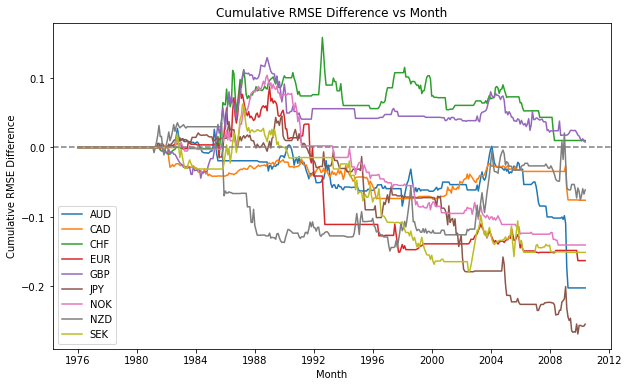

In [24]:
# Elastic Net
ecCumDiff, ecRsqOOS, ecHistMean = learnAndPlot(w, linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], 
                                                                            normalize = True, cv = 10), 
                                               fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [25]:
print("Mean R-Sq OOS over all currencies: ", np.mean(ecRsqOOS))

Mean R-Sq OOS over all currencies:  -0.0350554888162


In [26]:
#print("Performance compared to Historical Mean:", np.mean(ecRsqOOS) / calcSharpe(ecHistMean) * 100, "%")
print("Performance compared to Stock Sharpe Ratio:", np.mean(ecRsqOOS) / 0.012 * 100, "%")

Performance compared to Stock Sharpe Ratio: -292.129073468 %


In [27]:
for i in range(ecCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(ecCumDiff[ : , i]))

print("R square OOS: ", np.mean(ecRsqOOS))

Max DrawDown of  AUD : 0.229720029274
Max DrawDown of  CAD : 0.0809274859636
Max DrawDown of  CHF : 0.148340506438
Max DrawDown of  EUR : 0.253664708478
Max DrawDown of  GBP : 0.121540374137
Max DrawDown of  JPY : 0.31381697635
Max DrawDown of  NOK : 0.244427261796
Max DrawDown of  NZD : 0.184682592959
Max DrawDown of  SEK : 0.241810133681
R square OOS:  -0.0350554888162


#### Bayesian Ridge Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


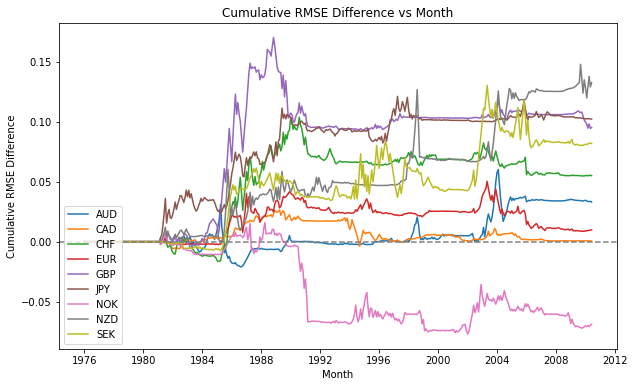

In [36]:
param_grid = {"lambda_1": [0.5, 1, 1.5]}
brCumDiff, brRsqOOS, brHistMean = learnAndPlot(w, GridSearchCV(linear_model.BayesianRidge(), param_grid = param_grid, cv = 10), 
                                               fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [37]:
print("Mean R-Sq OOS over all currencies: ", np.mean(brRsqOOS))

Mean R-Sq OOS over all currencies:  0.00558023558585


In [38]:
#print("Performance compared to Historical Mean:", np.mean(brRsqOOS) / calcSharpe(brHistMean) * 100, "%")
print("Performance compared to Stock Sharpe Ratio:", np.mean(brRsqOOS) / 0.012 * 100, "%")

Performance compared to Stock Sharpe Ratio: 46.5019632154 %


In [39]:
for i in range(brCumDiff.shape[1]):
   print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(brCumDiff[ : , i]))

print("R square OOS: ", np.mean(brRsqOOS))

Max DrawDown of  AUD : 0.0521641881661
Max DrawDown of  CAD : 0.0301679444309
Max DrawDown of  CHF : 0.0489820371446
Max DrawDown of  EUR : 0.0417526655268
Max DrawDown of  GBP : 0.0773854894808
Max DrawDown of  JPY : 0.0291282069952
Max DrawDown of  NOK : 0.0929894106441
Max DrawDown of  NZD : 0.0602917499762
Max DrawDown of  SEK : 0.0520720595905
R square OOS:  0.00558023558585


#### Learn With LASSO Selected Attributes

In [31]:
def learnAndPlot2(windowSize, model, fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff):
    # Windows Size
    w = windowSize

    # Random Forest Param Grid
    #param_grid = {"min_samples_leaf": [1, 3, 10]}

    cumDiffList = [] # Cumulative RMSE difference between prediction model and historical mean
    RsqrOOSList = [] # Final R-Square OOS for different currencies
    histMeanMatrix = []
    
    for currency in fxSpotDelta.columns.values:
        print("Currency = ", currency)
        histMean = []
        histMeanMSE = []
        modelMSE = []
        for yIdx in range(2, fxSpotDelta.shape[0] - w): # First y(i+1) ranges from 3 to 384
            #print("yIdx = ", yIdx)
            xIdx = yIdx - 1
            yMat = fxSpotDelta[currency].as_matrix()
            x1Mat = intDiff[currency].as_matrix()
            x2Mat = inflDiff[currency].as_matrix()
            x3Mat = indPrdDiff[currency].as_matrix()
            x4Mat = mSupplyDiff[currency].as_matrix()
            Y = yMat[yIdx:(yIdx + w)]
            X1 = x1Mat[xIdx:(xIdx + w)]
            X2 = x2Mat[xIdx:(xIdx + w)]
            X3 = x3Mat[xIdx:(xIdx + w)]
            X4 = x4Mat[xIdx:(xIdx + w)]
            X = np.vstack((X1, X2, X3, X4)).T
            
            # Historical Mean Calculation
            YhistPred = np.mean(Y)
            
            # Linear Regression Model
            #model = linear_model.LinearRegression()
            # LASSO with 10-fold cross validation to select the best alpha
            lassoModel = linear_model.LassoCV(cv = 10, normalize = True)
            lassoModel.fit(X, Y)
            idxAttrToUse = list(np.where(lassoModel.coef_ != 0)[0])
            if len(idxAttrToUse) == 0:
                YModelPred = YhistPred
            else:
                model.fit(X[ : , idxAttrToUse ], Y)
                PredX = np.array([[x1Mat[xIdx + w], x2Mat[xIdx + w], x3Mat[xIdx + w], x4Mat[xIdx + w]]])
                PredX = PredX[ : , idxAttrToUse ]
                YModelPred = model.predict(PredX)[0]
            # Random Forest without Cross Validation
            #model = ensemble.RandomForestRegressor(n_estimators = 20)
            # Random Forest with Grid Search CV
            #model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, cv = 10)
            actY = yMat[yIdx + w]
            histMean.append(YhistPred)
            histMeanMSE.append((YhistPred - actY)**2)
            modelMSE.append((YModelPred - actY)**2)

        # All the historical mean forecasts
        histMeanMatrix.append(histMean)
        
        # RMSE
        histMeanRMSE = np.sqrt(np.array(histMeanMSE))
        modelRMSE= np.sqrt(np.array(modelMSE))
        diffRMSE = histMeanRMSE - modelRMSE
        # R-Square OOS
        RsqrOOS = 1 - (np.sum(np.array(modelMSE)) / np.sum(np.array(histMeanMSE)))

        cumDiffList.append(np.insert(diffRMSE.cumsum(), 0, np.zeros(2 + w)))
        RsqrOOSList.append(RsqrOOS)

    cumDiff = np.array(cumDiffList).transpose()
    RsqrOOSAll = np.array(RsqrOOSList)
    histMeanMatrix = np.array(histMeanMatrix).transpose()
    #histMeanMatrix = fxSpotDelta.as_matrix()[(2 + w):, :]

    plt.figure(figsize = (10, 6))
    datesList = [datetime.strptime(str(date), '%Y%m').date() for date in fxSpotDelta.index.values]
    for i in range(cumDiff.shape[1]):
        plt.plot(datesList, cumDiff[:, i], label = fxSpotDelta.columns.values[i])
    plt.axhline(0, color = 'grey', ls = 'dashed')
    plt.title("Cumulative RMSE Difference vs Month")
    plt.xlabel("Month")
    plt.ylabel("Cumulative RMSE Difference")
    plt.legend(loc = 'lower left')
    plt.show()
    plt.close()
    
    return cumDiff, RsqrOOSAll, histMeanMatrix

#### Learn With Random Forest (LASSO-Selected Attributes)

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


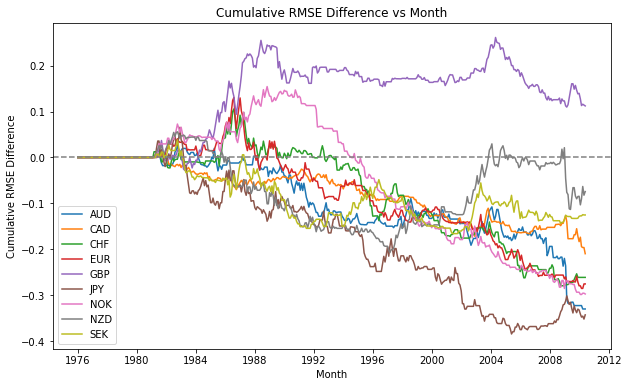

In [32]:
# Random Forest Regression with LASSO attributes
param_grid = {"min_samples_leaf": [1, 3, 10]}
rfCumDiff2, rfRsqOOS2, rfHistMean2 = learnAndPlot2(w, GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                                   param_grid = param_grid, cv = 10), 
                                                   fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [33]:
print("Mean R-Sq OOS over all currencies: ", np.mean(rfRsqOOS2))

Mean R-Sq OOS over all currencies:  -0.0617344615503


In [34]:
#print("Performance compared to Historical Mean:", np.mean(rfRsqOOS2) / calcSharpe(rfHistMean2) * 100, "%")
print("Performance compared to Stock Sharpe Ratio:", np.mean(rfRsqOOS2) / 0.012 * 100, "%")

Performance compared to Stock Sharpe Ratio: -514.453846252 %


In [35]:
for i in range(rfCumDiff2.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(rfCumDiff2[ : , i]))

Max DrawDown of  AUD : 0.355413925498
Max DrawDown of  CAD : 0.220527277767
Max DrawDown of  CHF : 0.384727828728
Max DrawDown of  EUR : 0.415215438936
Max DrawDown of  GBP : 0.151482118812
Max DrawDown of  JPY : 0.449573947154
Max DrawDown of  NOK : 0.452464291045
Max DrawDown of  NZD : 0.263060221881
Max DrawDown of  SEK : 0.203757018519
